# Charting Boulder: Population growth
[Brian C. Keegan, Ph.D.](http://www.brianckeegan.com)  
June 2025

Released under a [MIT License](https://opensource.org/licenses/MIT).

### Import packages

In [1]:
import pandas as pd
import numpy as np

idx = pd.IndexSlice

%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

import json, requests

### Read data

Load the "components of change" county estimates and forecasts from the [State Demography Office](https://demography.dola.colorado.gov/assets/html/sdodata.html).

In [61]:
components_df = pd.read_csv('components-change-county.csv',header=1)

# Clean up county names
components_df['countyname'] = components_df['countyname'].str.strip()

# Filter to Boulder County
components_boco_df = components_df[components_df['countyname'] == 'Boulder']

# Inspect
components_df.head()

,id,idtxt,countyfips,countyname,year,estimate,change,births,deaths,netmig,datatype
0,1,1970,0,Colorado,1970,2224610,58710,40348,17274,35636,Estimate
1,82,11970,1,Adams,1970,187058,6058,3608,835,3285,Estimate
2,163,31970,3,Alamosa,1970,11484,484,218,76,342,Estimate
3,244,51970,5,Arapahoe,1970,163683,5683,2645,858,3896,Estimate
4,325,71970,7,Archuleta,1970,2698,-342,57,19,-380,Estimate


Load and clean "historical census" data for municipalities and counties from the State Demography Office.

In [3]:
census_df = pd.read_csv('historical-census.csv')

# Remove irregular whitespaces
census_df['area_name'] = census_df['area_name'].str.strip()
census_df['area_type'] = census_df['area_type'].str.strip()
census_df['name_type'] = census_df['name_type'].str.strip()

# Filter out state-wide results
census_df = census_df.loc[census_df['area_name'] != 'COLORADO']

# Inspect
census_df.head()

,id,area_name,area_type,incorporation_year,county_incorporation,population_year,total_population,name_type
0,1,Aguilar,M,1894,Las Animas ...,1870,0,Aguilar_M
1,397,Aguilar,M,1894,Las Animas ...,1880,0,Aguilar_M
2,793,Aguilar,M,1894,Las Animas ...,1890,0,Aguilar_M
3,1189,Aguilar,M,1894,Las Animas ...,1900,698,Aguilar_M
4,1585,Aguilar,M,1894,Las Animas ...,1910,858,Aguilar_M


Load annual population estimates for counties and municipalities from 1980 to present.

In [6]:
county_muni_df = pd.read_csv('county-muni-timeseries.csv',header=1)

# Clean
county_muni_df['municipalityname'] = county_muni_df['municipalityname'].str.strip()

# Filter to Boulder County and city of Boulder
county_muni_county_pop_s = county_muni_df.loc[county_muni_df['municipalityname'] == 'BOULDER COUNTY',['year','totalpopulation']].set_index('year')['totalpopulation']
county_muni_city_pop_s = county_muni_df.loc[county_muni_df['municipalityname'] == 'Boulder',['year','totalpopulation']].set_index('year')['totalpopulation']

# Inspect
county_muni_df.head()

,id,countyfips,placefips,municipalityname,year,totalpopulation,countyplace
0,1,0,0,COLORADO STATE,1980,2889735.0,0
1,2,0,0,COLORADO STATE,1981,2980340.0,0
2,3,0,0,COLORADO STATE,1982,3064868.0,0
3,4,0,0,COLORADO STATE,1983,3137511.0,0
4,5,0,0,COLORADO STATE,1984,3174844.0,0


### Visualization diennial population growth

In [19]:
# Filter to City of Boulder population
c0 = census_df['area_name'] == 'Boulder'
c1 = census_df['area_type'] == 'M'
city_census_population_s = census_df.loc[c0 & c1].set_index('population_year')['total_population']

# Filter to Boulder County population
c0 = census_df['area_name'] == 'Boulder'
c1 = census_df['area_type'] == 'C'
county_census_population_s = census_df.loc[c0 & c1].set_index('population_year')['total_population']

# Add all county populations together for state population
co_state_population_s = census_df[census_df['area_type'] == 'C'].groupby('population_year')['total_population'].sum()

# Combine together
diennial_population = pd.concat(
    [city_census_population_s,county_census_population_s,co_state_population_s],
    axis=1,
    keys=['City','County','State']
)

diennial_population

,City,County,State
population_year,,,
1870,0,1939,39864
1880,0,9723,194327
1890,3339,14082,412198
1900,6150,21544,541483
1910,9539,30330,799044
1920,11006,31881,939191
1930,11223,32456,1035791
1940,12958,37438,1123296
1950,19999,48296,1325089


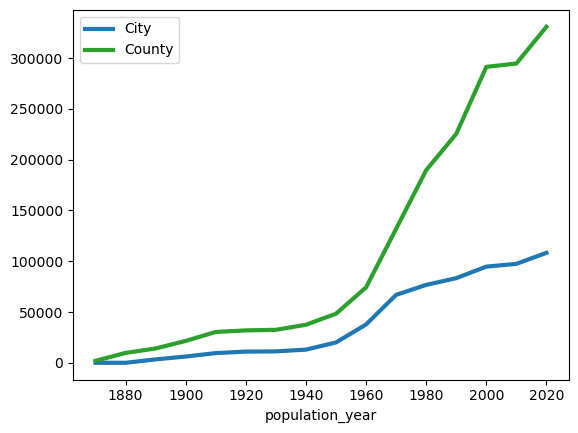

In [58]:
f,ax = plt.subplots()

diennial_population['City'].plot(ax=ax,color='tab:blue',label='City',lw=3)
diennial_population['County'].plot(ax=ax,color='tab:green',label='County',lw=3)
ax.legend()

### Visualize population growth since 1980-2021

In [42]:
# Join Series together
county_muni_df = pd.concat([county_muni_city_pop_s,county_muni_county_pop_s],axis=1,keys=['City','County'])

# Compute percentage change since 1980
county_muni_pct_df = county_muni_df.div(county_muni_df.loc[1980]) - 1

# Inspect
county_muni_pct_df.head()

,City,County
year,,
1980,0.000000,0.000000
1981,0.012897,0.027892
1982,0.021438,0.055647
1983,0.019874,0.079003
1984,0.042016,0.108635


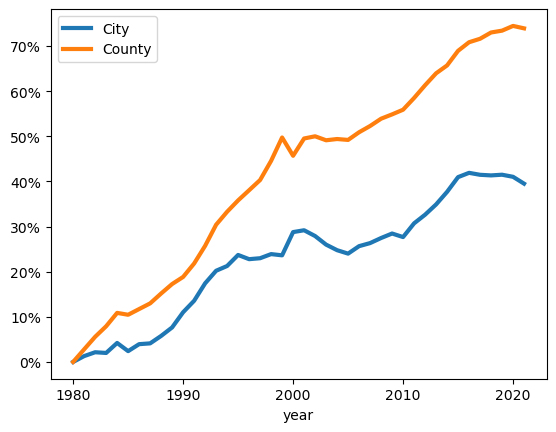

In [57]:
# Visualize
ax = county_muni_pct_df.plot(lw=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

### Visualize population growth rates since 1970

(-0.04, 0.08)

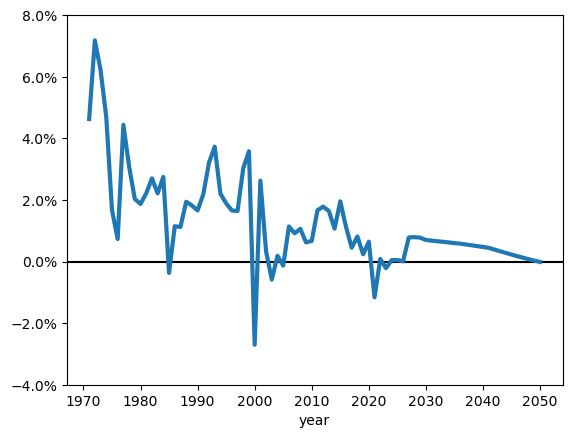

In [54]:
boco_growth_s = components_boco_df.set_index('year').loc[:,'estimate'].pct_change()

ax = boco_growth_s.plot(lw=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(0,c='black',zorder=-1)
ax.set_ylim((-0.04,0.08))

### Visualize share of Colorado population

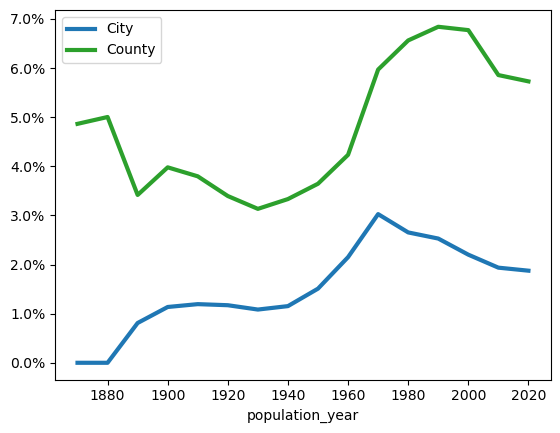

In [56]:
city_state_fraction = city_census_population_s / co_state_population_s
county_state_fraction = county_census_population_s / co_state_population_s

fraction_state_df = pd.concat([city_state_fraction,county_state_fraction],axis=1,keys=['City','County'])

f,ax = plt.subplots()
city_state_fraction.plot(ax=ax,color='tab:blue',label='City',lw=3)
county_state_fraction.plot(ax=ax,color='tab:green',label='County',lw=3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()

### Visualize rankings over time

In [15]:
municipal_census_pop_df = pd.pivot_table(
    data = census_df[census_df['area_type'] == 'M'],
    index = 'area_name',
    columns = 'population_year',
    values = 'total_population',
    aggfunc = 'max'
)

county_census_pop_df = pd.pivot_table(
    data = census_df[census_df['area_type'] == 'C'],
    index = 'area_name',
    columns = 'population_year',
    values = 'total_population',
    aggfunc = 'max'
)

municipal_census_pop_df.sort_values(by=2020,ascending=False).head(15)

population_year,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020
area_name,,,,,,,,,,,,,,,,
Denver,0.0,0.0,106713.0,133859.0,213381.0,256491.0,287861.0,322412.0,415786.0,493887.0,514678.0,492694.0,467610.0,554636.0,600158.0,715522.0
Colorado Springs,0.0,4226.0,11140.0,21085.0,29078.0,30105.0,33237.0,36789.0,45472.0,70194.0,135517.0,215105.0,281140.0,360890.0,417335.0,478961.0
Aurora,0.0,0.0,0.0,202.0,679.0,983.0,2205.0,3437.0,11421.0,48548.0,74974.0,158588.0,222103.0,276393.0,325078.0,386261.0
Fort Collins,0.0,1356.0,2011.0,3053.0,8210.0,8755.0,11489.0,12251.0,14937.0,25027.0,43337.0,65092.0,87758.0,118652.0,143986.0,169810.0
Lakewood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92743.0,113808.0,126481.0,144126.0,142980.0,155984.0
Thornton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11353.0,13326.0,42054.0,55031.0,82384.0,118772.0,141867.0
Arvada,0.0,0.0,0.0,0.0,840.0,915.0,1276.0,1482.0,2359.0,19242.0,49884.0,84576.0,89235.0,102153.0,106433.0,124402.0
Westminster,0.0,0.0,0.0,0.0,0.0,235.0,436.0,534.0,1686.0,13850.0,19512.0,50211.0,74625.0,100940.0,106114.0,116317.0
Pueblo,0.0,0.0,24558.0,28157.0,44395.0,43050.0,50096.0,52162.0,63685.0,91181.0,97774.0,101686.0,98640.0,102121.0,106595.0,111876.0


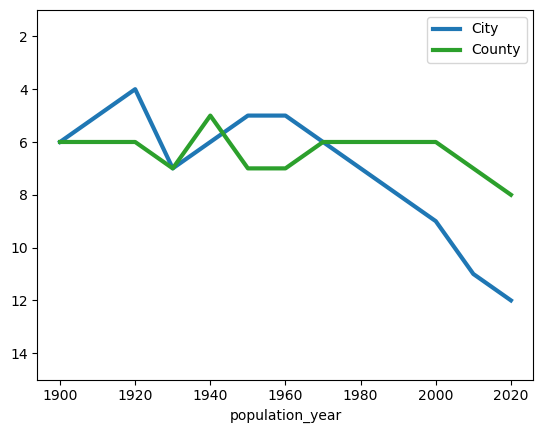

In [55]:
municipal_census_pop_rank = municipal_census_pop_df.rank(axis=0,method='first',ascending=False)
county_census_pop_rank = county_census_pop_df.rank(axis=0,method='first',ascending=False)

f,ax = plt.subplots()
municipal_census_pop_rank.loc['Boulder',1900:].plot(ax=ax,color='tab:blue',label='City',lw=3)
county_census_pop_rank.loc['Boulder',1900:].plot(ax=ax,color='tab:green',label='County',lw=3)
ax.set_ylim((1,15))
ax.invert_yaxis()
ax.legend()